In [1]:
# necessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from sklearn.metrics import *

import scipy.sparse as sparse

from sklearn.feature_selection import RFE
import tqdm

from sklearn.utils.class_weight import compute_class_weight 

import warnings
warnings.filterwarnings('ignore')

## 1. Load the data

In [2]:
df = pd.read_csv('../../Data/final_df.csv', usecols=['Sequence', 'Qualitative_Measure'])
df

,Sequence,Qualitative_Measure
0,DRAHYNIVTFCCKCD,Positive
1,MHGDTPTLHEYM,Positive
2,DSTLRLCVQSTHVD,Positive
3,RNGYRALMDKSLHVGTQCALTRR,Positive
4,SYVLEGTLTAEKTTLVVKEG,Positive
...,...,...
11420,AFMGYALPWGQMSFWGATVI,Negative
11421,QKLAPISIMYQISPPLNVSL,Positive
11422,SCSPTFSSDPLTTPPLMLTT,Negative
11423,PLPWALQTTNLPLMAMSSLL,Positive


In [3]:
# generating a 'bag-of-words' vector dataframe by converting the sequence information into matrix of tokens
vect = CountVectorizer(ngram_range=(1,3), analyzer='char', min_df=1)
df_nlp = vect.fit_transform(df['Sequence'])

In [4]:
df_nlp

<11425x7985 sparse matrix of type '<class 'numpy.int64'>'
	with 417622 stored elements in Compressed Sparse Row format>

In [5]:
# converting the sparse matrix into dataframe
df_nlp = pd.DataFrame(df_nlp.toarray())
df_nlp.columns = vect.get_feature_names()

In [6]:
df_nlp

,a,aa,aaa,aac,aad,aae,aaf,aag,aah,aai,...,yym,yyn,yyp,yyq,yyr,yys,yyt,yyv,yyw,yyy
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11420,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11421,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11423,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# splitting the dataset
X = df_nlp
y = df['Qualitative_Measure']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

# scaling
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

## 2. Decomposing the feature space using Principal Component Analysis

In [15]:
def decomposition_scorer(X_train, y_train, X_test, y_test, max_comp, min_comp, model):
    scores_train = []
    scores_val = []
    scores_test = []
    oversampler = SMOTE()
    
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train, random_state=42)
    X_tr_os, y_tr_os = oversampler.fit_resample(X_tr, y_tr)

    
    val = X_val.copy()  
    val['Qualitative_Measure'] = y_val
    val = val.sample(len(X_tr_os), replace=True)
            
    X_val_os = val.drop(columns='Qualitative_Measure')
    y_val_os = val['Qualitative_Measure'] 
            
    test = X_test.copy()
    test['Qualitative_Measure'] = y_test
    test = test.sample(len(X_tr_os), replace=True)
            
    X_test_os = test.drop(columns='Qualitative_Measure')
    y_test_os = test['Qualitative_Measure']
                                
    pca = PCA(n_components=max_comp)
    X_train_pca = pd.DataFrame(pca.fit_transform(X_tr_os), index = [n for n in range(len(X_tr_os))], columns = ['PC'+str(i) for i in range(1,max_comp+1)])
    X_val_pca = pd.DataFrame(pca.transform(X_val_os), index = [n for n in range(len(X_val_os))], columns = ['PC'+str(j) for j in range(1,max_comp+1)])
    X_test_pca = pd.DataFrame(pca.transform(X_test_os), index = [n for n in range(len(X_test_os))], columns = ['PC'+str(j) for j in range(1,max_comp+1)])
                
    for i in tqdm.tqdm((range(max_comp, min_comp, -150))):
        X_tr = X_train_pca.iloc[:, :i]
        y_tr = y_tr_os
        X_vl = X_val_pca.iloc[:, :i]
        y_vl = y_val_os
        X_tst = X_test_pca.iloc[:,:i]
        y_tst = y_test_os
                                                                                                                   
        model.fit(X_tr, y_tr)
        scores_train.append(matthews_corrcoef(y_tr, model.predict(X_tr)))
        scores_val.append(matthews_corrcoef(y_vl, model.predict(X_vl)))
        scores_test.append(matthews_corrcoef(y_tst, model.predict(X_tst)))
                       
    return scores_train, scores_val, scores_test   

In [17]:
logreg = LogisticRegression()
scores_train, scores_val, scores_test = decomposition_scorer(X_train_scaled, y_train, X_test_scaled, y_test, 7985, 200, logreg)

100%|███████████████████████████████████████████| 52/52 [01:45<00:00,  2.03s/it]


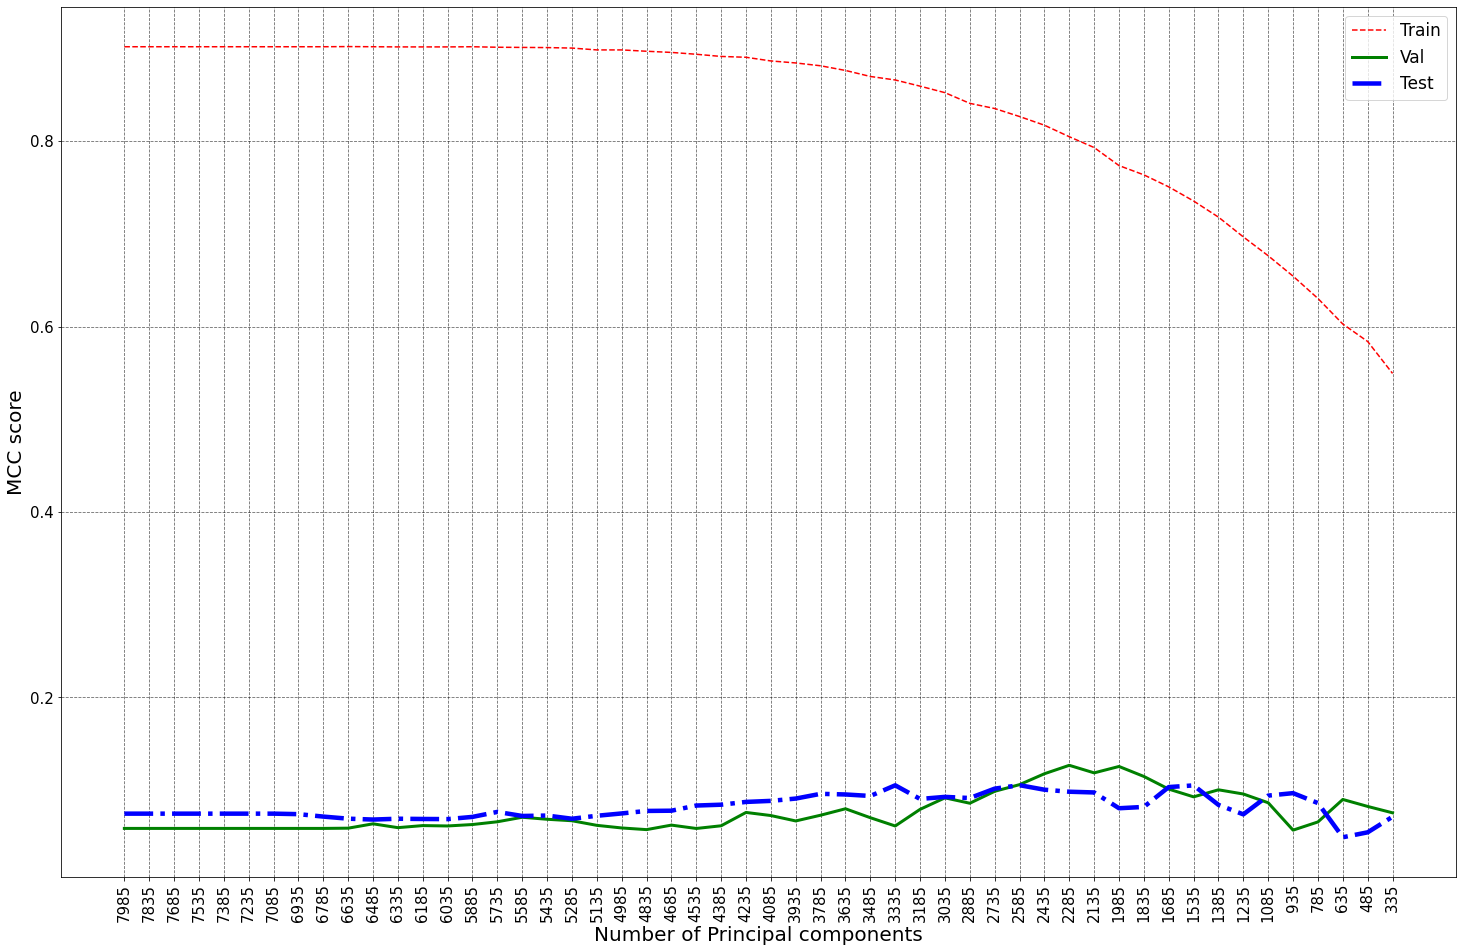

In [18]:
# visualising the result of PCA
plt.figure(figsize=(25, 16))
plt.plot(scores_train, label='Train', color='r', linewidth=1.5, linestyle='--')
plt.plot(scores_val, label ='Val' , color='g', linewidth=3)
plt.plot(scores_test, label='Test', color='b', linewidth=4.5, linestyle='-.')
plt.xticks(ticks = range(52), labels = range(7985,200,-150), rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('MCC score', fontsize=20)
plt.xlabel('Number of Principal components', fontsize=20)
plt.legend(fontsize=17)
plt.grid(alpha=0.6, color='k', linestyle='--')

Even PCA doesnt show promising results, performance on both the validation and the testing dataset remain consistently poor no matter the number of PCs. But still if I select the number of PCs to work with I will like to go with 3000 since this seems to be giving the most generalised results.

In [30]:
pca = PCA(n_components=7985)
X_pca = pca.fit_transform(X)

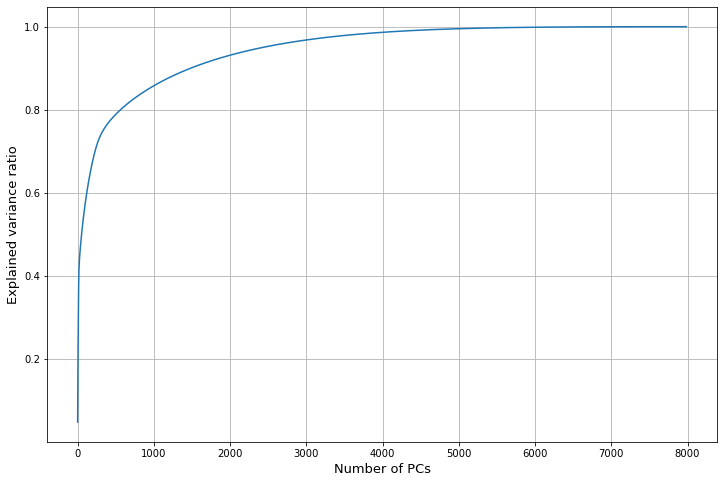

In [31]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCs', fontsize=13)
plt.ylabel('Explained variance ratio',fontsize=13)
plt.grid()

According to the above plot, around 5000 PCs explain 100% of the variance in the data, and 3000 PCs explain more than 90% of the variance and hence this seems to be a reasonable numbver of PCs to work with.

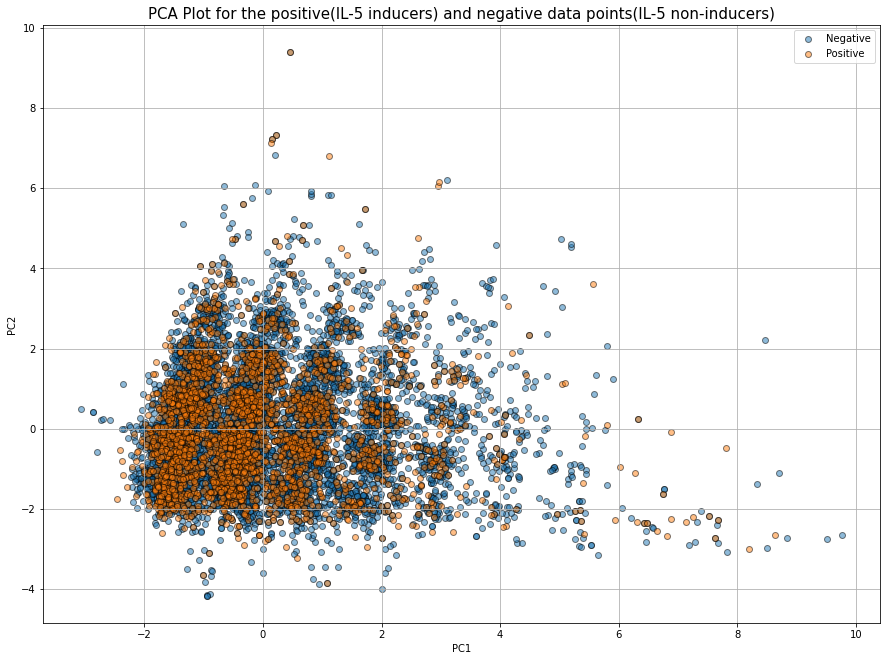

In [34]:
plt.figure(figsize=(15,11))
plt.scatter(x = X_pca[y[y == 'Negative'].index,0], y = X_pca[y[y == 'Negative'].index,1], label='Negative', alpha=0.5, edgecolors='k')
plt.scatter(x = X_pca[y[y == 'Positive'].index,0], y = X_pca[y[y == 'Positive'].index,1], label='Positive', alpha=0.5, edgecolors='k')
plt.title('PCA Plot for the positive(IL-5 inducers) and negative data points(IL-5 non-inducers)', fontsize=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid()

**We can again see that the negative(IL-5 non-inducers) and the positive(IL-5 inducers) datapoints are overlapping and hence even the peptide sequence information is unable to help distinguish between the two classes. So, we might probably again see a bad performance**

## 3. Training model 

In [35]:
pca = PCA(n_components=3000)

X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled), index=[n for n in range(len(X_train_scaled))], columns=[f'PC{i}' for i in range(1,3001)])
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), index=[n for n in range(len(X_test_scaled))], columns=[f'PC{i}' for i in range(1,3001)])

In [36]:
X_train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2991,PC2992,PC2993,PC2994,PC2995,PC2996,PC2997,PC2998,PC2999,PC3000
0,0.142264,-0.353809,0.277400,-0.049514,-0.199083,0.254388,0.899196,-0.053252,-0.220990,0.102372,...,0.014672,-0.007276,0.031694,-0.010885,0.021203,-0.030669,-0.015516,-0.050524,-0.004162,-0.020933
1,-0.574176,-0.114362,-0.233334,0.118212,-0.187720,0.808127,0.151083,-0.282796,-0.161176,0.093646,...,0.033760,0.008896,0.052006,0.023977,-0.004904,-0.006679,-0.038227,0.026248,-0.031400,-0.041428
2,-0.135822,-0.111209,0.718665,0.066273,0.245271,-0.179226,-0.146411,-0.175371,-0.089811,0.052973,...,0.030900,-0.017126,-0.000835,0.024426,0.000620,0.008084,0.037359,0.013499,0.010522,0.005854
3,0.043396,-0.534040,0.059374,-0.185676,0.098082,-0.077913,0.715963,0.530365,-0.624843,0.320413,...,-0.021831,0.001402,-0.011796,-0.008208,0.027778,-0.007463,-0.001245,0.011698,-0.005817,-0.002292
4,0.010659,0.128087,0.489121,0.502989,-0.011201,0.030287,0.143942,-0.371006,0.109689,0.122378,...,0.004613,-0.015244,0.028273,0.016268,-0.014975,0.005335,0.016113,0.003909,0.016892,0.014686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9135,0.311702,0.040903,-0.056334,0.267525,-0.156395,0.125729,0.258795,-0.358826,0.078098,0.185514,...,0.012757,0.005184,-0.026564,0.000864,-0.007463,0.006376,-0.016719,-0.035065,0.015487,0.023991
9136,0.027430,-0.210854,0.126997,0.038972,0.182243,-0.168033,-0.210958,-0.107856,0.062989,-0.167539,...,-0.037916,-0.028871,-0.049803,-0.021558,-0.013828,-0.027410,-0.001607,0.020607,0.033633,-0.006352
9137,-0.100140,0.335640,-0.040319,0.051094,-0.124446,0.330691,-0.211516,0.166757,-0.241249,-0.033429,...,-0.021206,0.010004,-0.029013,-0.002657,-0.033985,0.013581,-0.024167,-0.016269,-0.027288,0.059058
9138,0.310618,-0.253855,-0.041083,0.016996,-0.386532,-0.138205,0.018046,0.075619,0.371830,0.266034,...,-0.019625,0.022181,-0.012929,0.002167,0.023502,-0.021454,-0.013913,0.045913,0.045849,0.013047


In [37]:
X_test_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2991,PC2992,PC2993,PC2994,PC2995,PC2996,PC2997,PC2998,PC2999,PC3000
0,-0.248473,0.187607,-0.321012,0.225390,0.207026,0.397444,-0.363518,0.326367,0.140237,0.339113,...,0.015509,-0.014635,-0.042574,-0.022685,0.038970,0.007456,0.031232,0.028142,-0.004633,-0.003551
1,-0.187902,0.265951,-0.139517,-0.062140,0.090660,0.477160,-0.110301,0.241187,-0.135706,-0.005551,...,-0.155319,-0.073697,0.036570,0.055594,-0.036899,0.021094,0.007969,0.067420,0.048831,0.030123
2,-0.189830,0.459516,0.183494,0.049364,-0.050635,-0.050256,0.169275,0.132118,-0.031266,-0.274168,...,0.042872,0.009976,0.026270,0.031150,0.039958,0.005566,-0.034561,0.015737,-0.055340,-0.062847
3,-0.083142,-0.484372,0.413181,0.158023,0.134072,-0.073835,-0.184593,-0.011900,-0.285214,0.313661,...,-0.052984,-0.003099,-0.003315,-0.048075,0.059529,-0.059330,0.019904,-0.035784,0.059072,-0.000543
4,0.211226,0.085896,-0.131358,-0.079296,0.072043,-0.190886,0.128891,0.284873,-0.158754,-0.042620,...,0.042701,0.045012,0.027342,0.036692,0.017248,-0.058841,0.043377,-0.026919,0.097768,0.012383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,0.475081,0.907033,-0.109064,-0.244806,0.563034,-0.218539,0.465565,0.313174,-0.222130,0.043369,...,0.023659,-0.032949,0.000084,0.005095,0.049698,-0.054867,0.033230,-0.006143,-0.025082,0.022763
2281,-0.157648,0.115595,-0.017341,0.077133,-0.661557,0.069558,-0.290363,0.372356,0.201157,-0.026451,...,-0.011481,-0.029128,-0.062788,0.003466,-0.079014,0.048849,0.008853,-0.068291,-0.015821,0.033695
2282,0.085591,0.127339,0.223690,-0.179710,0.033563,-0.373341,0.439007,-0.198896,-0.191824,0.353635,...,0.045868,-0.034434,0.100229,0.005911,-0.021803,-0.007574,-0.032927,0.019821,-0.082564,0.033580
2283,0.069925,0.313730,0.004750,-0.202713,0.293804,-0.316506,0.304644,0.095640,0.064339,0.187807,...,-0.029860,0.104878,-0.006253,-0.020766,0.010694,-0.024967,-0.004880,-0.026183,0.005655,0.028922


In [38]:
# converting the datasets into sparse matrix for fast computation
X_train_pcaSparse = sparse.csr_matrix(X_train_pca.values)
X_test_pcaSparse = sparse.csr_matrix(X_test_pca.values)

In [39]:
X_train_pcaSparse

<9140x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 27420000 stored elements in Compressed Sparse Row format>

In [40]:
X_test_pcaSparse

<2285x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 6855000 stored elements in Compressed Sparse Row format>

In [41]:
# oversampling for balancing dataset
oversampler = SMOTE(random_state=42)
X_train_os, y_train_os = oversampler.fit_resample(X_train_pcaSparse, y_train)

In [42]:
# compute the class weights
classes = np.unique(y_train.to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{'Negative': 0.6584065696585506, 'Positive': 2.078217371532515}

In [43]:
# making our own scorer function for GridSearchCV
def matthews_correlation(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    mcc = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
    
    return mcc

mcc = make_scorer(matthews_correlation, greater_is_better=True)

### 1. LogisticRegression

In [44]:
# using class weights
logreg = LogisticRegression(class_weight=class_weights)

param_grid_lr = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]}

stratified = StratifiedKFold()

gridlr = GridSearchCV(logreg, param_grid_lr, cv=stratified, scoring=mcc, return_train_score=True, n_jobs=-1)

gridlr.fit(X_train_pcaSparse, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight={'Negative': 0.6584065696585506,
                                                        'Positive': 2.078217371532515}),
             n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [45]:
pd.DataFrame(gridlr.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

,params,mean_train_score,mean_test_score
4,{'C': 0.1},0.584547,0.150211
3,{'C': 0.01},0.424801,0.148879
2,{'C': 0.001},0.334078,0.143831
5,{'C': 0.3},0.650705,0.139171
1,{'C': 0.0001},0.321294,0.138155
6,{'C': 0.5},0.678334,0.135196
7,{'C': 0.7},0.693766,0.135083
8,{'C': 1},0.710274,0.134388
0,{'C': 1e-05},0.272210,0.124428


In [46]:
# saving the best model
modellr = gridlr.best_estimator_
modellr

LogisticRegression(C=0.1,
                   class_weight={'Negative': 0.6584065696585506,
                                 'Positive': 2.078217371532515})

In [47]:
# evaluating the performance
print(f"The confusion matrix:\n{confusion_matrix(y_test,modellr.predict(X_test_pcaSparse))}")
print(f"MCC score is:\n{matthews_corrcoef(y_test, modellr.predict(X_test_pcaSparse))}")

The confusion matrix:
[[1211  524]
 [ 290  260]]
MCC score is:
0.15372398087381633


In [48]:
# using oversampled data
logreg = LogisticRegression()

gridlr2 = GridSearchCV(logreg, param_grid_lr, cv=stratified, scoring=mcc, return_train_score=True, n_jobs=-1)

gridlr2.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [49]:
pd.DataFrame(gridlr2.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

,params,mean_train_score,mean_test_score
7,{'C': 0.7},0.790816,0.581095
6,{'C': 0.5},0.778814,0.578994
8,{'C': 1},0.801627,0.577667
5,{'C': 0.3},0.761386,0.577640
4,{'C': 0.1},0.712842,0.561916
3,{'C': 0.01},0.569595,0.494957
2,{'C': 0.001},0.481747,0.425470
1,{'C': 0.0001},0.463932,0.415142
0,{'C': 1e-05},0.461543,0.414094


In [50]:
modellr2 = gridlr2.best_estimator_
modellr2

LogisticRegression(C=0.7)

In [51]:
# evaluating the performance
print(f"The confusion matrix:\n{confusion_matrix(y_test,modellr2.predict(X_test_pcaSparse))}")
print(f"MCC score is:\n{matthews_corrcoef(y_test, modellr2.predict(X_test_pcaSparse))}")

The confusion matrix:
[[1381  354]
 [ 370  180]]
MCC score is:
0.124498046186692


### 2. Naive Bayes

In [51]:
# training the model
nb = MultinomialNB()

nb.fit(X_train_os, y_train_os)

# testing the performance
print(f"Confusion matrix for NB:\n {confusion_matrix(y_test, nb.predict(X_test_pcaSparse))}")
print(f"MCC score for NB: {matthews_corrcoef(y_test, nb.predict(X_test_pcaSparse))}")

ValueError: Negative values in data passed to MultinomialNB (input X)

these negative values are probably the negative PCA loadings..so if the naive bayes is not willing to accept these negative values do i need to scale after performing pca as well or should i simply not use naive bayes on pca dataset?


### 3. SupportVectorClassifier

In [54]:
# training the model with default parameters
svc = SVC(class_weight=class_weights)

svc.fit(X_train_pcaSparse, y_train)

SVC(class_weight={'Negative': 0.6584065696585506,
                  'Positive': 2.078217371532515})

In [57]:
# model performance
print(f"Confusion matrix for SVC\n: {confusion_matrix(y_test, svc.predict(X_test_pcaSparse))}")
print(f"MCC score for SVC: {matthews_corrcoef(y_test, svc.predict(X_test_pcaSparse))}")

Confusion matrix for SVC
: [[1485  250]
 [ 396  154]]
MCC score for SVC: 0.1522966412853276


### 4. RandomForestClassifier

In [53]:
# training the model with default parameters
rfc = RandomForestClassifier()

rfc.fit(X_train_os, y_train_os)

# evaluating the performance
matthews_corrcoef(y_test, rfc.predict(X_test_pcaSparse))

-0.10513826254650685

**For both SVC and RFC I have used the default parameters only since gridsearch was consuming a lot of memory and causing the kernel to die each time even on a sparse data matrix.**

### <font color='palevioletred'>CONCLUSION</font>
Even using PCA to reduce the dimensionality did not lead to noticeable improvement in the performance of the models.

So, overall even using Natural Language Processing to extract sequence information from the peptides did not help us in any way. But, I dont believe this to be an ultimate conclusion since there are probably ways to better extract the sequential information from the data and so I might keep updating the notebook as I keep learning.